In [1]:
from hashlib import new
import numpy as np
import random
import numba as nb
import matplotlib.pyplot as plt
from numpy.core.defchararray import count
from numpy.matrixlib import defmatrix
# from numpy.testing._private.utils import rand
from agent import *
from grid import *
import time

In [3]:
import dot_cython


In [15]:
%%cython
def fibonacci(n):
    if n<0:
        print("1st fibonacci number= 0")
    elif n==1:
        return 0
    elif n==2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)
fibonacci(39)

In [14]:
%time
fibonacci(39)

Wall time: 0 ns


NameError: name 'fibonacci' is not defined

In [16]:
%%cython -a
def fibonacci_c(int n):
    if n<0:
        print("1st fibonacci number = 0")
    elif n==1:
        return 0
    elif n==2:
        return 1
    else:
        return fibonacci_c(n-1)+fibonacci_c(n-2)

In [4]:
%%cython
class env:
    def __init__(self) -> None:
        self.map_size = [150,150]
        self.init_pop = 200 # 初始人口,500
        self.max_pop = 4000 # 人口上限,6000
        self.max_income = 5000 # 最高收入
        self.r = 0.005 # 收入增速
        self.R = 0.005 # 地价增速
        self.D = 0.1 # 地价折旧率
        self.c1 = 1.0 # 内部经济压力权重
        self.c2 = 1.0 # 内部社会压力权重
        self.ws = 1.0 # 外部压力权重
        self.wg = 1.0 # 内部压力权重
        self.a = 0.5 # 更新地价的权重
        self.move_step = 10 # 在周围[50,50]范围内计算候选迁居地块

        self.class_ratio = np.array([0.1,0.2,0.4,0.2,0.1]) # 低,中低,中,中高,高
        # 各个阶层的初始收入上下限，需要实时更新
        # 这些数字是通过将最高收入乘以一定系数得到的
        # 低收入阶层的收入范围是最高收入的[0,0.175],以此类推
        self.income = np.array([[100,175],   # 低
                                [175,350],   # 中低
                                [350,500],   # 中
                                [500,750],   # 中高
                                [750,1000]]) # 高
        self.WT = 0.15 # 迁居阈值
        self.grid = Grid(map_size=self.map_size)
        self.work_income() # 为每个企业分配随机收入增速
        
        self.agent_pool = {}
        self.pop_size = len(self.agent_pool)
        
        self.gen_agent(N=500)

    def work_income(self,):
        '''
        为不同的企业赋予不同的收入增速
        按理说，最大收入也应该是区分不同企业的
        '''
        self.num_work = self.grid.work_xy.shape[0]
        self.r_work = [random.uniform(self.r*0.8,self.r*1.2) for _ in range(self.num_work)]
        return None
        
    # @nb.jit()
    def step(self):
        '''
        单步执行函数
        改变收入，更新地价，执行每个智能体的迁居判断
        改变每个阶层的收入范围
        将移走的地块重新置为0
        '''
        
        shuffle_list = random.sample(list(self.agent_pool),len(self.agent_pool))
        
        for idx in shuffle_list:
            agent = self.agent_pool[idx]
            flag = self.move(agent.index) # 决定是否搬家，以及完成搬家操作
        
        self.update_income()
        print('update income done')
        self.update_value()
        print('update value done')
        return None

    def update_income(self):
        '''
        更新群体收入和所属阶层
        更新各阶层收入范围
        '''
        self.income_list = []
        shuffle_pool = random.sample(list(self.agent_pool),len(self.agent_pool)) # 打乱更新顺序
        for idx in shuffle_pool:
            a = self.agent_pool[idx]
            a_work = a.work_id
            income = a.update_income(self.r_work[a_work], self.max_income)
            self.income_list.append(income)
        max_income = np.max(self.income_list)
        
        # 更新智能体的阶层、视域和权重
        for a in self.agent_pool:
            a.def_class(max_income)
        
        # 更新各阶层收入取值范围
        self.income = np.array([[0,0.175],
                                [0.175,0.35],
                                [0.35,0.5],
                                [0.5,0.75],
                                [0.75,1.0]]) * max_income



    def cal_in_pressure(self, ID, xy):
        '''
        计算内部社会经济压力
        S_h^t = c1*|I_h^t - V_h^t| + c2*|I_h^t - P_h^t|
        S是社会经济压力
        I是个人收入
        V是所占据土地的价值
        P是邻居平均经济状况
        c1、c2是系数
        '''
        x,y = xy
        income = self.agent_pool[ID].income
        price = self.grid.val_map[x,y] # 所占土地地价
        P = self.neighbor(xy) # 邻里平均经济状况
        S = self.c1 * np.abs(income-price) + self.c2 * np.abs(income-P)
        # print('income,',income,P)
        return S

    def is_agent(self,xy):
        '''
        判断当前地块是空地还是被智能体占据
        ID > 999是ID号
        ID = 0是空地
        '''
        x,y = xy
        ID = self.grid.use_map[x,y]
        if ID > 999:   return ID
        elif ID < 999: return 0

    def neighbor(self,xy,offset=5):
        '''
        计算邻里平均经济状况
        也就是xy周围一定范围内的土地/智能体的价值之平均
        若地块空闲，则计算地价，若地块有人居住，则计算智能体收入
        
        '''
        x,y = xy
        dir = self.meshgrid(offset=[offset,offset])
        sum = []
        for off_x,off_y in dir:
            if ((x+off_x) >= 0) and ((x+off_x)<self.map_size[0]) and ((y+off_y) >= 0) and ((y+off_y)<self.map_size[1]): # 不越界
                if self.grid.use_map[x+off_x,y+off_y] >= 0: # 能访问
                    id = self.is_agent([x+off_x,y+off_y]) # 查找该地块上有没有人居住
                    if id >= 1000: # 1000以上的id代表agent
                        sum.append(self.agent_pool[id].income) # 收入
                    elif id < 1000: # 1000以下的id代表空地
                        sum.append(self.grid.val_map[x+off_x,y+off_y]) # 地价
        return np.mean(sum)

    def occupation(self,xy,offset=10):
        '''
        计算邻域内被占据的格点数（已出租房屋）占比
        总地块数量要排除不能访问的地块
        input：中心点坐标
        output：已占据格点数/总格点数
        '''
        x,y = xy
        dir = self.meshgrid(offset=[offset,offset])
        n_occupied, n_total = 0, 0
        for off_x,off_y in dir:
            if ((x+off_x) >= 0) and ((x+off_x)<self.map_size[0]) and ((y+off_y) >= 0) and ((y+off_y)<self.map_size[1]): # 不越界
                if self.grid.use_map[x+off_x,y+off_y] >= 0: # 能访问
                    n_total += 1
                    if self.grid.use_map[x+off_x,y+off_y] >= 1000: # 1000以上的id代表agent
                        n_occupied += 1
        return n_occupied / n_total

        
    
    def meshgrid(self,offset=[10,10],pop=True):
        '''
        生成类似于如下的矩阵
        ((-1,-1),(-1,0),(-1,1),
        (0,-1),         (0,1),
        (1,-1),(1,0),(1,1))
        '''
        x_offset,y_offset = offset
        dir = []
        for x in range(-x_offset,x_offset):
            for y in range(-y_offset,y_offset):
                dir.append([x,y])
        if pop:
            dir.pop(int(0.5*2*x_offset*2*y_offset+y_offset)) # 刨除(0,0)点

        return dir

    def neighbor_value(self,xy,offset=10):
        '''
        计算周围土地的价值
        input：xy坐标
        output：地价list和均值
        '''
        x,y = xy
        dir = self.meshgrid(offset=[offset,offset])
        n_value = []
        for off_x,off_y in dir:
            if ((x+off_x) >= 0) and ((x+off_x)<self.map_size[0]) and ((y+off_y) >= 0) and ((y+off_y)<self.map_size[1]): # 不越界
                if self.grid.use_map[x+off_x,y+off_y] >= 0: # 能访问
                    n_value.append(self.grid.val_map[x+off_x,y+off_y])
        return n_value, np.mean(n_value)

    def cal_out_pressure(self, xy, work_xy, weight):
        '''
        计算给定坐标的外部居住环境吸引力
        G_h^t = w_env*E_env + w_edu*E_edu + w_tra*E_tra + w_pri*E_pri + w_con*E_con
        Agent权重的排序: 交通、通勤、地价
        '''
        
        '''环境、教育、基础设施
        E_env = np.min(np.sqrt(np.sum((self.grid.env_xy-xy)**2,1)))
        E_env = np.exp(1-0.001*E_env) # 指数距离衰减函数

        E_edu = np.min(np.sqrt(np.sum((self.grid.edu_xy-xy)**2,1)))
        E_edu = np.exp(1-0.001*E_edu) # 指数距离衰减函数
        
        E_inf = np.min(np.sqrt(np.sum((self.grid.inf_xy-xy)**2,1)))
        E_inf = np.exp(1-0.001*E_inf) # 指数距离衰减函数
        '''
        x,y = xy
        # 交通        
        E_tra = np.min(np.sqrt(np.sum((self.grid.tra_xy-xy)**2,1))) # 与最近地铁站点的距离
        E_tra = np.exp(1-0.001*E_tra) # 指数距离衰减函数
        
        # 通勤
        E_work = np.sqrt(np.sum((work_xy-xy)**2)) # 和指定的企业计算通勤距离
        # E_work = np.sum(np.abs(work_xy-xy)) # 曼哈顿距离

        # 房价
        # 实际上外部吸引力与房价并非正比关系，而是对不同人群有不同影响，人们可能更偏好比当前收入稍好一点的房屋，但不喜欢房价高出很多的房屋
        E_price = 0.001 * self.grid.val_map[x,y] 
        return weight * np.array([E_tra,E_work,E_price])

    def location_effect(self,ID,xy):
        '''
        计算区位效应
        U = wg * G + ws * (1 - S) + e
        G是外部吸引力
        S是内部压力
        e是随机变量
        xy可以是ID的坐标，也可以不是
        因此可以计算给定位置的Agent与另一块土地的假设区位效应
        
        '''
        
        weight = self.agent_pool[ID].weight # 智能体的权重
        work_id = self.agent_pool[ID].work_id
        work_xy = self.grid.work_xy[work_id]
        G = self.cal_out_pressure(xy, work_xy, weight).sum() # 外部居住环境吸引力
        S = self.cal_in_pressure(ID, xy) # ID智能体在xy位置的内部压力
        LocationEffect = self.wg*G + self.ws*(1-S) + 0.1*np.random.rand()
        # print("LE:",S)
        return LocationEffect 

    def move(self,ID):
        '''
        判断迁居阈值，选择迁居地

        计算迁居意愿
        AW = U_best - U
        AW >= WT，迁居
        AW < WT，不迁居
        U_best是Agent视域内最佳居住点的区位效应
        '''
        
        '''
        注意：当meshgrid很大时，计算location effect将极其耗费时间
        应该采用内部压力和外部
        '''
        xy = self.agent_pool[ID].coord
        x,y = xy
        dir = self.meshgrid(offset=[self.move_step, self.move_step])
        is_occupied = []
        le = []
        for off_x,off_y in dir:
            if ((x+off_x)>=0) and \
                ((x+off_x)<self.map_size[0]) and \
                ((y+off_y)>=0) and \
                ((y+off_y)<self.map_size[1]): # 不越界

                if self.grid.use_map[x+off_x,y+off_y] >= 0: # 是可用地块
                    id = self.is_agent([x+off_x,y+off_y])
                    if id <= 999: # 空地
                        L_E = self.location_effect(ID,[x+off_x,y+off_y]) # ID智能体在[x+off_x,y+off_y]位置的区位效应
                        # print(L_E)
                        le.append(L_E)
                        is_occupied.append([x+off_x,y+off_y])
        max_le = np.max(le)
        AW = max_le - self.location_effect(ID,xy)
        if AW >= self.WT: # 超过迁居阈值
            # print(le)
            prob = self.softmax(le)
            destination = np.random.choice(list(range(len(le))),p=prob)
            destination_xy = is_occupied[destination]
            xx,yy = destination_xy
            self.grid.use_map[xx,yy] = ID # 新位置
            self.grid.use_map[x,y] = 0 # 原位置归0

            return True
        else:
            return False

    def softmax(self,x):
        '''softmax函数'''
        x = np.array(x)
        xx = np.exp(x)/(np.exp(x).sum())
        return xx

    def update_value(self):
        '''
        改变土地价值
        土地价值与上一时刻的地价、Agent所持有的财富、周边地价有关
        若土地被Agent占据：
        V_{ij}^{t+1} = a*(1+R)*V_{ij}^t 
                        + (1-a)*[(I_h^t+\sum_{m \in \Omega(\hat{ij})} V_m^t)/9]
        a是权重
        R是地价增速
        \sum_{m \in \Omega(\hat{ij})} V_m^t是智能体周围8个地块的地价之和

        若土地未被Agent占据，则价值随时间折旧：
        V_{ij}^{t+1} = a*(1-D)*V_{ij}^t 
                        + (1-a)*[(\sum_{m \in \Omega(ij)} V_m^t)/9]
        D是折旧率
        
        for x in range(self.map_size[0]):
            for y in range(self.map_size[1]):
                ID = self.is_agent(np.array([x,y]))
                V = self.grid.val_map[x,y] # 当前地价
                V_n = self.neighbor_value([x,y]) # 邻居的地价
                if ID: # 被智能体占据
                    income = self.agent_pool[ID].income # 当前收入
                    
                    V_n.append(income)
                    V_n = np.mean(V_n)
                    self.grid.val_map[x,y] = self.a*(1+self.R)*V + (1-self.a)*V_n
                elif not ID: # 空地
                    V_n.append(V)
                    V_n = np.mean(V_n)
                    self.grid.val_map[x,y] = self.a*(1-self.D)*V + (1-self.a)*V_n
        '''

        '''
        新的更新规则是：
        地价变化由三部分组成，供需关系+历史地价+周围影响
        供需关系是周围地块的租赁状况对当前地块的价格影响，周围租出去的地块越多，说明越可能是卖方市场，价格会被推高，反之则应该被衰减
        历史地价是上一时刻的当前地价
        周围影响是周围地块的平均地价

        供需关系：乘性关系
        历史地价、周围影响：加性关系
        新地价 = 供需关系缩放因子*（历史地价+周围影响）
        '''

        x_shuffle = random.sample(list(range(self.map_size[0])),self.map_size[0])
        y_shuffle = random.sample(list(range(self.map_size[1])),self.map_size[1])
        # 随机顺序更新地价
        for x in x_shuffle:
            for y in y_shuffle:
                if self.grid.use_map[x,y] >= 0: # 可访问地块
                    history_value = self.grid.val_map[x,y]
                    _, neighbor_value = self.neighbor_value([x,y])
                    neighbor_occupy = self.occupation([x,y])
                    if neighbor_occupy >= 0.8 and neighbor_occupy < 1:      factor = 1.10
                    elif neighbor_occupy >= 0.6 and neighbor_occupy < 0.8:  factor = 1.05
                    elif neighbor_occupy >= 0.4 and neighbor_occupy < 0.6:  factor = 1.00
                    elif neighbor_occupy >= 0.2 and neighbor_occupy < 0.4:  factor = 0.95
                    elif neighbor_occupy >= 0.0 and neighbor_occupy < 0.2:  factor = 0.90

                    new_value = factor * (0.5*history_value + 0.5*neighbor_value)
                    self.grid.val_map[x,y] = new_value



    def gen_agent(self, N):
        '''
        生成新智能体
        N:新增总人口
        '''
        
        number = np.floor(N * self.class_ratio) # 将新增总人口按收入阶层比例划分
        
        for i in range(5): # 为5个阶层产生新人口
            for _ in range(int(number[i])):

                # while部分的另一种写法是：
                # 找出use_map的全部空地，随机选一个，这样更快
                '''
                xy = np.random.randint(self.map_size)     # 随机生成位置
                x,y = xy
                while self.grid.use_map[x,y] != 0:        # 如果该位置被占据或不能放置，则重新生成
                    xy = np.random.randint(self.map_size)
                    x,y = xy
                '''
                                
                idxs = np.argwhere(self.grid.use_map==0)
                xy = random.choice(idxs)
                x,y = xy


                ID = self.pop_size + 1000                 # 用ID为智能体建立索引
                self.grid.use_map[x,y] = ID               # 在use_map中更新智能体的ID
                l,h = self.income[i]                      # 各个阶层的初始收入上下限
                income = np.random.randint(low=l, high=h) # 随机收入
                work_id = random.choice(range(self.num_work)) # 随机分配一个企业
                self.agent_pool[ID] = Agent(ID,xy,income,self.WT,work_id)
                self.pop_size += 1

    def render(self):
        '''
        可视化self.grid.use_map
        根据ID找到Agent的阶层
        在新画布上区分出agent的阶层
        '''
        new_figure = np.zeros(self.map_size[0],self.map_size[1],3)
        for id in list(self.agent_pool.keys()):
            x,y = self.agent_pool[id].coord
            clas = self.agent_pool[id].clas
            # 根据阶层上色
            if clas == 'Low':          new_figure[x,y,:] = np.array([220,220,220])
            elif clas == 'MediumLow':  new_figure[x,y,:] = np.array([170,170,170])
            elif clas == 'Medium':     new_figure[x,y,:] = np.array([120,120,120])
            elif clas == 'MediumHigh': new_figure[x,y,:] = np.array([70,70,70])
            elif clas == 'High':       new_figure[x,y,:] = np.array([20,20,20])
        for x,y in self.grid.work_xy:
            new_figure[x,y,:] = [220,50,170] # 标注企业位置
        for x,y in self.grid.tra_xy:
            new_figure[x,y,:] = [50,170,220] # 标注地铁站
        
        return new_figure



T = 10 # 仿真步长

# 初始化模拟器
Environment = env()
# 生成初始人口
Environment.gen_agent(500)
# 开始仿真
for t in range(T):
    t1 = time.time()
    Environment.step()
    t2 = time.time()
    print(t2-t1)

    img = Environment.render()
    print(img.shape)
    plt.imshow(img)




In [37]:
offset = [20,18]
x_offset,y_offset = offset
tmp = []
for x in range(-x_offset,x_offset):
    for y in range(-y_offset,y_offset):
        tmp.append([x,y])

In [59]:
r_work = [random.uniform(.005*0.8,.005*1.2) for _ in range(10)]

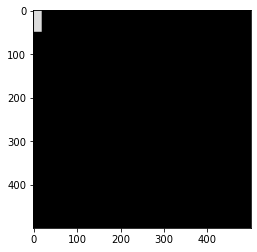

In [182]:
# a = np.round(np.random.rand(50,50)*255)
new_figure = np.zeros((500,500,3),dtype=int)
new_figure[1,2:20,:] = [220,220,220]
plt.imshow(new_figure)

In [6]:
import numpy as np
np.random.choice(np.arange(10),10)

array([2, 4, 7, 0, 1, 3, 5, 1, 7, 9])

In [185]:
import numpy as np
from bqplot import Graph, LinearScale, ColorScale, Figure, Tooltip
from ipywidgets import Layout

fig_layout = Layout(width='600px', height='600px')

node_data = [
    dict(label='A', shape='rect'),
    dict(label='B', shape='ellipse'),
    dict(label='C', shape='ellipse'),
    dict(label='D', shape='rect'),
    dict(label='E', shape='ellipse'),
    dict(label='F', shape='circle'),
    dict(label='G', shape='ellipse'),
]
link_data = [{'source': s, 'target': t} for s, t in np.random.randint(0, 7, (10, 2)) if s != t]
graph = Graph(node_data=node_data, link_data=link_data, charge=-600, colors=['lightblue'] * 7)
graph.link_type = 'arc' # arc, line, slant_line
Figure(marks=[graph], layout=fig_layout)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='600px', width='600…